<a href="https://colab.research.google.com/github/Serghei-S/No_PyTorch/blob/main/No_PyTorch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Раздел

In [29]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

np.random.seed(42)
RUN_GRADIENT_CHECKS = False

In [30]:
class Module:
    def __init__(self):
        self.output = None
        self.gradInput = None
        self.training = True
    def forward (self, x):                return self.updateOutput(x)
    def backward(self, x, gradOut):
        self.updateGradInput(x, gradOut)
        self.accGradParameters(x, gradOut)
        return self.gradInput

    def updateOutput   (self, x):           raise NotImplementedError
    def updateGradInput(self, x, gradOut):  raise NotImplementedError
    def accGradParameters(self, x, gradOut):   pass
    def zeroGradParameters(self):              pass
    def getParameters      (self):             return []
    def getGradParameters  (self):             return []

    def train   (self): self.training = True
    def evaluate(self): self.training = False
    def __repr__(self): return self.__class__.__name__

class Sequential(Module):
    def __init__(self):
        super().__init__()
        self.modules = []

    def add(self, m): self.modules.append(m)

    def updateOutput(self, x):
        self._saved_inputs = [x] # Сохраняем вход всей последовательности
        out = x
        for m in self.modules:
            out = m.forward(out)
            self._saved_inputs.append(out) # Сохраняем выход каждого модуля
        self.output = out
        return self.output

    def backward(self, x, gradOut): # x здесь не используется напрямую, т.к. входы сохранены
        grad = gradOut
        # Проходим по слоям в обратном порядке
        # grad_input для слоя N становится grad_output для слоя N-1
        # вход для слоя N - это self._saved_inputs[N] (выход слоя N-1 или вход всей сети)
        for idx in reversed(range(len(self.modules))):
            inp  = self._saved_inputs[idx] # Вход для текущего слоя m_idx
            grad = self.modules[idx].backward(inp, grad)
        self.gradInput = grad
        return self.gradInput

    def zeroGradParameters(self):
        for m in self.modules: m.zeroGradParameters()
    def getParameters(self):
        return [m.getParameters() for m in self.modules if m.getParameters()] # Пропускаем пустые списки
    def getGradParameters(self):
        return [m.getGradParameters() for m in self.modules if m.getGradParameters()]

    def train(self):
        super().train()
        for m in self.modules: m.train()
    def evaluate(self):
        super().evaluate()
        for m in self.modules: m.evaluate()
    def __repr__(self):
        return "Sequential:\n" + '\n'.join(["  " + str(m) for m in self.modules])

class Linear(Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        stdv = 1. / np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, (n_out, n_in)).astype(np.float32)
        self.b = np.random.uniform(-stdv, stdv, (n_out,)).astype(np.float32)
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, x):
        self.output = x.dot(self.W.T) + self.b
        return self.output

    def updateGradInput(self, x, gradOut):
        self.gradInput = gradOut.dot(self.W)
        return self.gradInput

    def accGradParameters(self, x, gradOut):
        self.gradW += np.dot(gradOut.T, x) # Суммируем градиенты по батчу
        self.gradb += np.sum(gradOut, axis=0) # Суммируем градиенты по батчу

    def zeroGradParameters(self):
        self.gradW.fill(0); self.gradb.fill(0)
    def getParameters    (self): return [self.W, self.b]
    def getGradParameters(self): return [self.gradW, self.gradb]
    def __repr__(self): return f'Linear {self.W.shape[1]} -> {self.W.shape[0]}'

class SoftMax(Module):
    def updateOutput(self, x):
        # Стабилизация: вычитаем максимум из каждой строки
        z = x - x.max(axis=1, keepdims=True)
        exp = np.exp(z)
        self.output = exp / exp.sum(axis=1, keepdims=True)
        return self.output
    def updateGradInput(self, x, gradOut):
        # s_i * (delta_ij * gradOut_j - s_j * gradOut_j)
        s = self.output # s_i
        # (gradOut * s) -> (g1*s1, g2*s2, ...)
        # sum(axis=1) -> (sum(gi*si))
        # keepdims=True -> [[sum(gi*si)], [sum(gj*sj)], ...]
        dot_product = (gradOut * s).sum(axis=1, keepdims=True) # sum_k (gradOut_k * s_k)
        self.gradInput = s * (gradOut - dot_product)
        return self.gradInput
    def __repr__(self): return 'SoftMax'

class LogSoftMax(Module):
    def updateOutput(self, x):
        # x_i - log(sum(exp(x_j)))
        # Стабилизация: z_i = x_i - max(x)
        # log(sum(exp(z_j))) + max(x)
        # output = z_i - log(sum(exp(z_j)))
        z = x - x.max(axis=1, keepdims=True)
        self.output = z - np.log(np.exp(z).sum(axis=1, keepdims=True))
        return self.output
    def updateGradInput(self, x, gradOut):
        # gradOut_i - exp(y_i) * sum(gradOut_j)
        exp_y = np.exp(self.output)
        self.gradInput = gradOut - exp_y * gradOut.sum(axis=1, keepdims=True)
        return self.gradInput
    def __repr__(self): return 'LogSoftMax'

class BatchNormalization(Module):
    EPS = 1e-5 # Изменено с 1e-3 для большей стабильности в некоторых случаях
    def __init__(self, n_features, alpha=0.9): # alpha для скользящего среднего
        super().__init__()
        self.alpha = alpha
        self.moving_mean = np.zeros(n_features, dtype=np.float32)
        self.moving_variance = np.ones(n_features, dtype=np.float32)

        # Параметры для обучения: gamma и beta (делаем их частью BN)
        self.gamma = np.ones(n_features, dtype=np.float32)
        self.beta = np.zeros(n_features, dtype=np.float32)
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, x):
        if self.training:
            self.current_mean = x.mean(axis=0)
            self.current_var = x.var(axis=0)
            self.current_std_inv = 1. / np.sqrt(self.current_var + self.EPS)
            self.x_centered = x - self.current_mean
            self.x_norm = self.x_centered * self.current_std_inv

            self.output = self.gamma * self.x_norm + self.beta

            # Обновление скользящих средних
            self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * self.current_mean
            self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * self.current_var
        else:
            x_norm = (x - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)
            self.output = self.gamma * x_norm + self.beta
        return self.output

    def updateGradInput(self, x, gradOut):
        # Градиенты для gamma и beta вычисляются в accGradParameters
        # Здесь вычисляем dL/dx_norm
        grad_x_norm = gradOut * self.gamma

        if self.training:
            N = x.shape[0]
            # dL/d_var = sum(dL/dx_norm_i * (x_i - mu) * (-0.5) * (var + eps)^(-1.5))
            grad_var = np.sum(grad_x_norm * self.x_centered * (-0.5) * self.current_std_inv**3, axis=0)
            # dL/d_mu = sum(dL/dx_norm_i * (-1/std)) + dL/d_var * (sum(-2*(x_i-mu))/N)
            grad_mu = np.sum(grad_x_norm * (-self.current_std_inv), axis=0) + \
                      grad_var * np.sum(-2. * self.x_centered, axis=0) / N
            # dL/dx_i = dL/dx_norm_i * (1/std) + dL/d_var * (2*(x_i-mu)/N) + dL/d_mu * (1/N)
            self.gradInput = grad_x_norm * self.current_std_inv + \
                             grad_var * (2. * self.x_centered / N) + \
                             grad_mu / N
        else: # На стадии inference градиенты по входу проще
            self.gradInput = grad_x_norm / np.sqrt(self.moving_variance + self.EPS)
        return self.gradInput

    def accGradParameters(self, x, gradOut):
        if self.training: # Обновляем градиенты gamma и beta только во время обучения
            self.gradGamma += np.sum(gradOut * self.x_norm, axis=0)
            self.gradBeta += np.sum(gradOut, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self): return [self.gamma, self.beta]
    def getGradParameters(self): return [self.gradGamma, self.gradBeta]
    def __repr__(self): return f'BatchNormalization(features={self.gamma.shape[0]})'


class ChannelwiseScaling(Module): # Уже встроено в BatchNormalization, но оставим для совместимости
    def __init__(self, n_out):
        super().__init__()
        stdv = 1. / np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, n_out).astype(np.float32)
        self.beta  = np.random.uniform(-stdv, stdv, n_out).astype(np.float32)
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta  = np.zeros_like(self.beta)

    def updateOutput(self, x):
        self.output = x * self.gamma + self.beta
        return self.output
    def updateGradInput(self, x, gradOut):
        self.gradInput = gradOut * self.gamma
        return self.gradInput
    def accGradParameters(self, x, gradOut):
        self.gradGamma += np.sum(gradOut * x, axis=0)
        self.gradBeta  += np.sum(gradOut,    axis=0)
    def zeroGradParameters(self):
        self.gradGamma.fill(0); self.gradBeta.fill(0)
    def getParameters    (self): return [self.gamma, self.beta]
    def getGradParameters(self): return [self.gradGamma, self.gradBeta]
    def __repr__(self): return f'ChannelwiseScaling(features={self.gamma.shape[0]})'

class Dropout(Module):
    def __init__(self, p=0.5):
        super().__init__()
        assert 0 <= p < 1, "Dropout probability must be between 0 and 1"
        self.p = p
        self.mask = None

    def updateOutput(self, x):
        if self.training and self.p > 0:
            self.keep_prob = 1. - self.p
            self.mask = (np.random.rand(*x.shape) < self.keep_prob).astype(x.dtype)
            self.output = x * self.mask / self.keep_prob # Inverted dropout
        else:
            self.output = x
        return self.output

    def updateGradInput(self, x, gradOut):
        if self.training and self.p > 0:
            self.gradInput = gradOut * self.mask / self.keep_prob
        else:
            self.gradInput = gradOut
        return self.gradInput
    def __repr__(self): return f'Dropout(p={self.p})'

class ReLU(Module):
    def updateOutput(self, x):
        self.output = np.maximum(x, 0)
        return self.output
    def updateGradInput(self, x, gradOut):
        self.gradInput = gradOut * (x > 0)
        return self.gradInput
    def __repr__(self): return 'ReLU'

class LeakyReLU(Module):
    def __init__(self, slope=0.03):
        super().__init__()
        self.slope = slope
    def updateOutput(self, x):
        self.output = np.where(x > 0, x, self.slope * x)
        return self.output
    def updateGradInput(self, x, gradOut):
        self.gradInput = gradOut * np.where(x > 0, 1., self.slope)
        return self.gradInput
    def __repr__(self): return f'LeakyReLU(slope={self.slope})'

class ELU(Module):
    def __init__(self, alpha=1.):
        super().__init__()
        self.alpha = alpha
    def updateOutput(self, x):
        self.output = np.where(x > 0, x, self.alpha * (np.exp(x) - 1.))
        return self.output
    def updateGradInput(self, x, gradOut):
        # производная ELU(x): 1 if x > 0 else alpha * exp(x)
        # alpha * exp(x) = alpha * ( (ELU(x)/alpha + 1) -1 + exp(x) ) = ELU(x) + alpha (для x <=0)
        deriv = np.where(x > 0, 1., self.output + self.alpha) # Corrected from your original
        self.gradInput = gradOut * deriv
        return self.gradInput
    def __repr__(self): return f'ELU(alpha={self.alpha})'

class SoftPlus(Module):
    def updateOutput(self, x):
        # log(1 + exp(x))
        # Более стабильная версия: log(1 + exp(-abs(x))) + max(0, x)
        self.output = np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)
        return self.output
    def updateGradInput(self, x, gradOut):
        # Производная SoftPlus это сигмоида: 1 / (1 + exp(-x))
        sigm = 1. / (1. + np.exp(-x))
        self.gradInput = gradOut * sigm
        return self.gradInput
    def __repr__(self): return 'SoftPlus'

class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        assert kernel_size % 2 == 1, "Kernel size must be odd for 'same' padding simulation"
        self.k = kernel_size
        self.pad = self.k // 2 # 'same' padding

        # Инициализация весов (например, Kaiming/He для ReLU-сетей, но здесь простой stdv)
        stdv = 1. / np.sqrt(in_channels * kernel_size * kernel_size)
        self.W = np.random.uniform(-stdv, stdv,
                                   (out_channels, in_channels, kernel_size, kernel_size)).astype(np.float32)
        self.b = np.random.uniform(-stdv, stdv, (out_channels,)).astype(np.float32)
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, x):
        # x: (N, C_in, H_in, W_in)
        self.N, self.C_in, self.H_in, self.W_in = x.shape
        self.C_out = self.W.shape[0]

        # Выходные размеры с 'same' padding
        self.H_out, self.W_out = self.H_in, self.W_in

        self.x_padded = np.pad(x, ((0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)), mode='constant')
        self.output = np.zeros((self.N, self.C_out, self.H_out, self.W_out), dtype=x.dtype)

        for n in range(self.N): # по батчу
            for c_out in range(self.C_out): # по выходным каналам (фильтрам)
                conv_sum = np.zeros((self.H_out, self.W_out), dtype=x.dtype)
                for c_in in range(self.C_in): # по входным каналам
                    # scipy.signal.correlate2d(input, kernel, mode='valid') == cross-correlation
                    # scipy.signal.convolve2d(input, np.rot90(kernel, 2), mode='valid')
                    conv_sum += sig.correlate2d(self.x_padded[n, c_in],
                                                self.W[c_out, c_in],
                                                mode='valid') # 'valid' так как мы сделали padding вручную
                self.output[n, c_out] = conv_sum + self.b[c_out]
        return self.output

    def updateGradInput(self, x, gradOut):
        # gradOut: (N, C_out, H_out, W_out)
        self.gradInput = np.zeros_like(x) # (N, C_in, H_in, W_in)

        # Для dL/dX нужна полная свертка (full convolution) gradOut с развернутыми фильтрами W_rot180
        # W_rot180 = self.W[:, :, ::-1, ::-1] # Разворот фильтров на 180 градусов

        # Паддинг для gradOut, чтобы получить размер gradInput после full-свертки
        # Если k=3, pad=1. Full свертка (H_out, W_out) с (k,k) даст (H_out+k-1, W_out+k-1)
        # Нам нужно отрезать по краям (k-1-pad) с каждой стороны.
        # Для 'same' (pad = (k-1)/2), отрезаем (k-1-(k-1)/2) = (k-1)/2 = pad.

        # Проще: паддим gradOut так, чтобы свертка с W_rot дала нужный размер dX_padded
        # Затем снимаем паддинг с dX_padded

        gradOut_padded = np.pad(gradOut, ((0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)), mode='constant')

        # W_flipped по пространственным измерениям
        W_flipped = self.W[:,:,::-1,::-1] # (C_out, C_in, k, k)

        for n in range(self.N):
            for c_in in range(self.C_in):
                acc_grad_in = np.zeros((self.H_in + 2*self.pad, self.W_in + 2*self.pad), dtype=x.dtype)
                for c_out in range(self.C_out):
                    # dL/dX_cin = sum_{cout} (dL/dY_cout *conv_full* W_cout_cin_flipped)
                    # scipy.signal.convolve2d(A, B_flipped) == scipy.signal.correlate2d(A,B)
                    # Нам нужна свертка gradOut с W_flipped, что эквивалентно корреляции gradOut с W (не флипнутым дважды)
                    # gradInput_padded[n, c_in] += sig.convolve2d(gradOut[n, c_out], W_flipped[c_out, c_in, :, :], mode='full')
                    # Используем correlate, т.к. это операция, обратная forward correlate
                    # dL/dX = dL/dY ** W_rot180 (свертка)
                    # dL/dX = dL/dY corr W (если forward был X corr W)
                    # Forward: Y = X corr W_forward. dL/dX = dL/dY conv W_forward_rot180
                    # dL/dX = dL/dY corr W_forward (если W_forward симметричен, но это не так)
                    # gradOut (N, Cout, H, W), W_flipped (Cout, Cin, K, K)
                    # Нам нужно (N, Cin, H_pad, W_pad)
                    # Для каждого входного канала c_in:
                    # sum_{c_out} ( gradOut[:, c_out] conv W_flipped[c_out, c_in] )
                    acc_grad_in += sig.convolve2d(gradOut_padded[n, c_out], W_flipped[c_out, c_in, :, :], mode='valid')
                # Обрезаем паддинг, который был добавлен для x, чтобы получить gradInput для исходного x
                self.gradInput[n, c_in] = acc_grad_in #[self.pad:-self.pad, self.pad:-self.pad]

        return self.gradInput

    def accGradParameters(self, x, gradOut): # x здесь - это self.x_padded из forward
        # dL/dW_filter = X_padded corr dL/dY
        # dL/db = sum(dL/dY)
        for n in range(self.N):
            for c_out in range(self.C_out):
                for c_in in range(self.C_in):
                    # gradW[c_out, c_in] += X_padded[n, c_in] corr gradOut[n, c_out]
                    self.gradW[c_out, c_in] += sig.correlate2d(self.x_padded[n, c_in],
                                                               gradOut[n, c_out],
                                                               mode='valid')
                self.gradb[c_out] += np.sum(gradOut[n, c_out])

    def zeroGradParameters(self):
        self.gradW.fill(0); self.gradb.fill(0)
    def getParameters    (self): return [self.W, self.b]
    def getGradParameters(self): return [self.gradW, self.gradb]
    def __repr__(self): return f'Conv2d {self.C_in}->{self.C_out}, k={self.k}'

class MaxPool2d(Module):
    def __init__(self, kernel_size, stride=None):
        super().__init__()
        self.k = kernel_size
        self.s = stride if stride is not None else kernel_size # По умолчанию stride = kernel_size

    def updateOutput(self, x):
        # x: (N, C, H_in, W_in)
        self.N, self.C, self.H_in, self.W_in = x.shape

        self.H_out = (self.H_in - self.k) // self.s + 1
        self.W_out = (self.W_in - self.k) // self.s + 1

        self.output = np.zeros((self.N, self.C, self.H_out, self.W_out), dtype=x.dtype)
        self.max_indices = np.zeros_like(self.output, dtype=int) # Для backward

        for n in range(self.N):
            for c in range(self.C):
                for i in range(self.H_out):
                    for j in range(self.W_out):
                        h_start, w_start = i * self.s, j * self.s
                        h_end, w_end = h_start + self.k, w_start + self.k
                        window = x[n, c, h_start:h_end, w_start:w_end]
                        self.output[n, c, i, j] = np.max(window)
                        # Сохраняем индекс максимального элемента относительно окна
                        # np.argmax возвращает плоский индекс, преобразуем его в 2D
                        flat_idx = np.argmax(window)
                        self.max_indices[n,c,i,j] = np.unravel_index(flat_idx, window.shape)[0] * self.k + \
                                                   np.unravel_index(flat_idx, window.shape)[1]
        return self.output

    def updateGradInput(self, x, gradOut):
        # gradOut: (N, C, H_out, W_out)
        self.gradInput = np.zeros_like(x)
        for n in range(self.N):
            for c in range(self.C):
                for i in range(self.H_out):
                    for j in range(self.W_out):
                        h_start, w_start = i * self.s, j * self.s
                        # h_end, w_end = h_start + self.k, w_start + self.k # не нужны здесь

                        # Получаем 2D индекс из сохраненного плоского индекса внутри окна k*k
                        idx_in_window_row = self.max_indices[n, c, i, j] // self.k
                        idx_in_window_col = self.max_indices[n, c, i, j] % self.k

                        # Преобразуем в абсолютные индексы в self.gradInput
                        abs_idx_row = h_start + idx_in_window_row
                        abs_idx_col = w_start + idx_in_window_col

                        self.gradInput[n, c, abs_idx_row, abs_idx_col] += gradOut[n, c, i, j]
        return self.gradInput
    def __repr__(self): return f'MaxPool2d k={self.k}, stride={self.s}'

In [31]:
class Criterion:
    def __init__(self):
        self.output = None
        self.gradInput = None
    def forward (self, inp, tgt): return self.updateOutput(inp, tgt)
    def backward(self, inp, tgt): return self.updateGradInput(inp, tgt)
    def updateOutput   (self, inp, tgt): raise NotImplementedError
    def updateGradInput(self, inp, tgt): raise NotImplementedError
    def __repr__(self): return self.__class__.__name__


class MSECriterion(Criterion):
    def updateOutput(self, inp, tgt):
        self.output = np.mean((inp - tgt) ** 2)
        return self.output
    def updateGradInput(self, inp, tgt):
        # dL/dinp = 2 * (inp - tgt) / N (N - общее число элементов в inp)
        self.gradInput = 2 * (inp - tgt) / inp.size # Делим на общее число элементов
        return self.gradInput

class ClassNLLCriterionUnstable(Criterion): # Используйте ClassNLLCriterion с LogSoftMax
    EPS = 1e-15
    def updateOutput(self, p, tgt): # p - вероятности (выход SoftMax)
        p_c = np.clip(p, self.EPS, 1. - self.EPS)
        # tgt - one-hot encoding
        self.output = -np.sum(tgt * np.log(p_c)) / p.shape[0] # Среднее по батчу
        return self.output
    def updateGradInput(self, p, tgt):
        p_c = np.clip(p, self.EPS, 1. - self.EPS)
        self.gradInput = -(tgt / p_c) / p.shape[0]
        return self.gradInput

class ClassNLLCriterion(Criterion): # Для использования с LogSoftMax
    def updateOutput(self, log_p, tgt): # log_p - логарифм вероятностей (выход LogSoftMax)
        # tgt - one-hot encoding
        self.output = -np.sum(tgt * log_p) / log_p.shape[0] # Среднее по батчу
        return self.output
    def updateGradInput(self, log_p, tgt):
        self.gradInput = -tgt / log_p.shape[0]
        return self.gradInput

# --- Оптимизаторы ---
def sgd_momentum(variables, grads, config, state):
    # variables: list of lists of parameters (e.g. [[W1, b1], [W2, b2]])
    # grads: list of lists of gradients
    state.setdefault('accumulated_grads', [
        [np.zeros_like(p) for p in layer_params] for layer_params in variables
    ])

    lr = config['learning_rate']
    mu = config.get('momentum', 0.0) # .get() для опционального параметра

    for i, (layer_params, layer_grads) in enumerate(zip(variables, grads)):
        for j, (param, grad) in enumerate(zip(layer_params, layer_grads)):
            acc_grad = state['accumulated_grads'][i][j]
            np.multiply(acc_grad, mu, out=acc_grad)      # acc_grad = mu * acc_grad
            np.add(acc_grad, grad, out=acc_grad)         # acc_grad = acc_grad + grad (не lr*grad здесь)

            param -= lr * acc_grad # Обновление весов

def adam_optimizer(variables, grads, config, state):
    state.setdefault('m', [[np.zeros_like(p) for p in lp] for lp in variables])
    state.setdefault('v', [[np.zeros_like(p) for p in lp] for lp in variables])
    state.setdefault('t', 0)
    state['t'] += 1

    lr = config['learning_rate']
    beta1 = config.get('beta1', 0.9)
    beta2 = config.get('beta2', 0.999)
    epsilon = config.get('epsilon', 1e-8)

    # Коррекция смещения для m и v (bias correction)
    lr_t = lr * np.sqrt(1 - beta2**state['t']) / (1 - beta1**state['t'])

    for i, (layer_params, layer_grads) in enumerate(zip(variables, grads)):
        for j, (param, grad) in enumerate(zip(layer_params, layer_grads)):
            m_param = state['m'][i][j]
            v_param = state['v'][i][j]

            np.multiply(m_param, beta1, out=m_param)
            np.add(m_param, (1 - beta1) * grad, out=m_param) # m_t = beta1*m_{t-1} + (1-beta1)*g_t

            np.multiply(v_param, beta2, out=v_param)
            np.add(v_param, (1 - beta2) * (grad**2), out=v_param) # v_t = beta2*v_{t-1} + (1-beta2)*g_t^2

            param -= lr_t * m_param / (np.sqrt(v_param) + epsilon)


In [32]:
def check_gradient_numerical(func, x, grad_analytic, epsilon=1e-5):
    """Численно проверяет градиент для функции func(x)."""
    grad_numerical = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        old_value = x[ix]

        x[ix] = old_value + epsilon
        fx_plus_e = func(x)

        x[ix] = old_value - epsilon
        fx_minus_e = func(x)

        grad_numerical[ix] = (fx_plus_e - fx_minus_e) / (2 * epsilon)
        x[ix] = old_value # restore
        it.iternext()

    rel_error = np.linalg.norm(grad_analytic - grad_numerical) / \
                (np.linalg.norm(grad_analytic) + np.linalg.norm(grad_numerical) + 1e-9) # +1e-9 для стабильности
    return rel_error, grad_numerical


def check_layer_gradients(layer, input_data, grad_output, epsilon=1e-5, tol=1e-5):
    print(f"--- Checking Layer: {layer!r} ---")
    layer.train() # Убедимся, что слой в режиме обучения для корректной проверки BN/Dropout

    # Сохраняем оригинальные параметры для восстановления
    original_params_values = [p.copy() for p in layer.getParameters()]

    # --- 1. Проверка gradInput (dL/dX) ---
    # Аналитический gradInput
    _ = layer.forward(input_data.copy()) # Forward pass для обновления внутренних состояний (если есть)
    analytical_grad_input = layer.backward(input_data.copy(), grad_output.copy())

    # Численный gradInput
    def loss_fn_dx(current_input):
        output = layer.forward(current_input)
        return np.sum(output * grad_output) # L = sum(Y_i * dL/dY_i)

    rel_error_dx, _ = check_gradient_numerical(loss_fn_dx, input_data.copy(), analytical_grad_input, epsilon)

    assert rel_error_dx < tol, \
        f"GradInput: Relative error {rel_error_dx:.2e} > tol {tol:.1e}"
    print(f"  GradInput check PASSED (Rel. Err: {rel_error_dx:.2e})")

    # --- 2. Проверка gradParameters (dL/dW) ---
    layer_params = layer.getParameters()
    if not layer_params:
        print(f"  No parameters to check for {layer!r}")
        # Восстанавливаем оригинальные параметры слоя перед выходом
        for i, p_orig in enumerate(original_params_values):
            layer.getParameters()[i][...] = p_orig[...]
        return

    layer.zeroGradParameters()
    _ = layer.forward(input_data.copy()) # forward
    _ = layer.backward(input_data.copy(), grad_output.copy()) # backward, чтобы accGradParameters сработал
    analytical_grad_params_list = layer.getGradParameters()

    for i, (param_ref, grad_param_analytical) in enumerate(zip(layer_params, analytical_grad_params_list)):
        # param_ref - это ссылка на параметр в слое, будем менять его напрямую

        def loss_fn_dp(current_param_value_ignored): # current_param_value_ignored не используется, т.к. меняем param_ref
            # Здесь param_ref уже изменен в check_gradient_numerical
            output = layer.forward(input_data.copy())
            return np.sum(output * grad_output)

        # Важно: check_gradient_numerical будет изменять param_ref.
        # Мы передаем param_ref.copy() в check_gradient_numerical, чтобы он оперировал с копией,
        # но внутри loss_fn_dp мы все равно используем измененный param_ref из слоя.
        # Поэтому нужно передавать сам param_ref в check_gradient_numerical.

        rel_error_dp, _ = check_gradient_numerical(loss_fn_dp, param_ref, grad_param_analytical, epsilon)

        assert rel_error_dp < tol, \
            f"GradParam[{i}]: Relative error {rel_error_dp:.2e} > tol {tol:.1e}"
        print(f"  GradParam[{i}] check PASSED (Rel. Err: {rel_error_dp:.2e})")

    # Восстанавливаем оригинальные параметры слоя
    for i, p_orig in enumerate(original_params_values):
        layer.getParameters()[i][...] = p_orig[...]
    print("--- Check Layer Done ---")


def check_criterion_gradients(criterion, input_data, target_data, epsilon=1e-5, tol=1e-5):
    print(f"--- Checking Criterion: {criterion!r} ---")
    # Аналитический градиент
    _ = criterion.forward(input_data.copy(), target_data.copy()) # Для кеширования, если есть
    analytical_grad = criterion.backward(input_data.copy(), target_data.copy())

    # Численный градиент
    def loss_fn(current_input):
        return criterion.forward(current_input, target_data.copy())

    rel_error, _ = check_gradient_numerical(loss_fn, input_data.copy(), analytical_grad, epsilon)

    assert rel_error < tol, \
        f"GradInput: Relative error {rel_error:.2e} > tol {tol:.1e}"
    print(f"  GradInput check PASSED (Rel. Err: {rel_error:.2e})")
    print("--- Check Criterion Done ---")

In [33]:
def run_all_gradient_checks():
    print("========== RUNNING GRADIENT CHECKS ==========")
    # Общие данные для тестов
    batch_size = 2
    input_features = 5
    output_features = 3
    np.random.seed(123) # Локальный сид для тестов

    # ---- Тесты слоев ----
    # Linear
    input_lin = np.random.randn(batch_size, input_features).astype(np.float32)
    grad_out_lin = np.random.randn(batch_size, output_features).astype(np.float32)
    linear_layer = Linear(input_features, output_features)
    check_layer_gradients(linear_layer, input_lin, grad_out_lin, tol=1e-4)

    # ReLU
    input_relu = np.random.randn(batch_size, output_features).astype(np.float32)
    input_relu[0,0] = 0 # для проверки граничного случая
    grad_out_relu = np.random.randn(batch_size, output_features).astype(np.float32)
    relu_layer = ReLU()
    check_layer_gradients(relu_layer, input_relu, grad_out_relu, tol=1e-4)

    # SoftMax
    input_softmax = np.random.randn(batch_size, output_features).astype(np.float32)
    grad_out_softmax = np.random.randn(batch_size, output_features).astype(np.float32)
    # grad_out_softmax -= grad_out_softmax.mean(axis=1, keepdims=True) # Для большей устойчивости теста Softmax
    softmax_layer = SoftMax()
    check_layer_gradients(softmax_layer, input_softmax, grad_out_softmax, tol=1e-4)

    # LogSoftMax
    logsoftmax_layer = LogSoftMax()
    check_layer_gradients(logsoftmax_layer, input_softmax, grad_out_softmax, tol=1e-4)

    # BatchNormalization
    bn_features = 4
    input_bn = np.random.randn(batch_size, bn_features).astype(np.float32) * 2 + 3 # Сдвиг и масштаб
    grad_out_bn = np.random.randn(batch_size, bn_features).astype(np.float32)
    bn_layer = BatchNormalization(bn_features)
    check_layer_gradients(bn_layer, input_bn, grad_out_bn, tol=5e-3) # BN может быть менее точным

    # Dropout (проверяем в режиме training)
    dropout_layer = Dropout(p=0.5)
    dropout_layer.train()
    check_layer_gradients(dropout_layer, input_relu.copy(), grad_out_relu.copy(), tol=1e-4)

    # Conv2d (может быть медленно, используем маленькие размеры)
    N, C_in, H, W = 1, 1, 5, 5 # Маленькие размеры для скорости
    C_out, K = 1, 3
    input_conv = np.random.randn(N, C_in, H, W).astype(np.float32)
    grad_out_conv = np.random.randn(N, C_out, H, W).astype(np.float32) # H, W такие же из-за 'same'
    conv_layer = Conv2d(C_in, C_out, K)
    # Увеличиваем epsilon и tol для сверток, т.к. там много суммирований
    check_layer_gradients(conv_layer, input_conv, grad_out_conv, epsilon=1e-3, tol=5e-3)

    # MaxPool2d
    N_pool, C_pool, H_pool, W_pool = 1, 1, 6, 6
    K_pool = 2
    input_pool = np.random.randn(N_pool, C_pool, H_pool, W_pool).astype(np.float32)
    grad_out_pool = np.random.randn(N_pool, C_pool, H_pool//K_pool, W_pool//K_pool).astype(np.float32)
    pool_layer = MaxPool2d(K_pool)
    # MaxPool не имеет параметров, но проверяем gradInput. Может быть неточен из-за argmax.
    check_layer_gradients(pool_layer, input_pool, grad_out_pool, tol=1e-4)

    # ---- Тесты критериев ----
    # MSECriterion
    pred_mse = np.random.randn(batch_size, output_features).astype(np.float32)
    target_mse = np.random.randn(batch_size, output_features).astype(np.float32)
    mse_criterion = MSECriterion()
    check_criterion_gradients(mse_criterion, pred_mse, target_mse, tol=1e-4)

    # ClassNLLCriterion (с выходом LogSoftMax)
    pred_logprobs = logsoftmax_layer.forward(input_softmax.copy()) # Используем выход LogSoftMax
    target_nll_idx = np.random.randint(0, output_features, size=batch_size)
    target_nll_onehot = np.zeros((batch_size, output_features), dtype=np.float32)
    target_nll_onehot[np.arange(batch_size), target_nll_idx] = 1.0
    nll_criterion = ClassNLLCriterion()
    check_criterion_gradients(nll_criterion, pred_logprobs, target_nll_onehot, tol=1e-4)

    print("========== GRADIENT CHECKS COMPLETED ==========")

In [34]:
def generate_synthetic_data(n_samples=200, n_features=2, n_classes=2):
    """Генерирует простые данные для классификации (спирали или блобы)."""
    X = np.zeros((n_samples * n_classes, n_features), dtype=np.float32)
    y = np.zeros(n_samples * n_classes, dtype=int)

    for j in range(n_classes):
        ix = range(n_samples * j, n_samples * (j + 1))
        r = np.linspace(0.0, 1, n_samples)  # radius
        t = np.linspace(j * 4, (j + 1) * 4, n_samples) + np.random.randn(n_samples) * 0.2  # theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j

    # Перемешиваем данные
    perm = np.random.permutation(len(X))
    X, y = X[perm], y[perm]

    # Преобразуем y в one-hot encoding
    y_one_hot = np.zeros((len(y), n_classes), dtype=np.float32)
    y_one_hot[np.arange(len(y)), y] = 1.0

    return X, y_one_hot, y # Возвращаем y_orig для вычисления точности

def train_example_model():
    print("\n========== TRAINING EXAMPLE MODEL ==========")
    # 1. Данные
    n_samples_per_class = 100
    n_features = 2
    n_classes = 3
    X_train, y_train_onehot, y_train_orig = generate_synthetic_data(n_samples_per_class, n_features, n_classes)
    plt.figure(figsize=(6, 4))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train_orig, s=40, cmap=plt.cm.Spectral, edgecolors='k')
    plt.title("Synthetic Training Data")
    plt.show()
    model = Sequential()
    model.add(Linear(n_features, 64))
    model.add(BatchNormalization(64))
    model.add(ReLU())
    model.add(Linear(64, n_classes))
    model.add(LogSoftMax())

    print("\nModel Architecture:")
    print(model)

    # 3. Критерий и Оптимизатор
    criterion = ClassNLLCriterion()
    optimizer_config = {'learning_rate': 1e-1, 'momentum': 0.9} # SGD
    # optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999} # Adam
    optimizer_state = {}
    optimizer_fn = sgd_momentum # или adam_optimizer

    # 4. Цикл обучения
    epochs = 1000
    batch_size = 32
    losses = []
    accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_correct_predictions = 0
        epoch_total_predictions = 0
        model.train() # Переводим модель в режим обучения

        # Перемешивание данных на каждой эпохе
        permutation = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[permutation]
        y_shuffled_onehot = y_train_onehot[permutation]
        y_shuffled_orig = y_train_orig[permutation]

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch_onehot = y_shuffled_onehot[i:i+batch_size]
            y_batch_orig = y_shuffled_orig[i:i+batch_size]

            # Forward pass
            predictions_logprobs = model.forward(X_batch)

            # Compute loss
            loss = criterion.forward(predictions_logprobs, y_batch_onehot)
            epoch_loss += loss * X_batch.shape[0] # Суммируем потери, домноженные на размер батча

            # Backward pass
            grad_loss = criterion.backward(predictions_logprobs, y_batch_onehot)
            model.backward(X_batch, grad_loss) # X_batch здесь формально, т.к. входы кешируются в Sequential

            # Optimizer step
            optimizer_fn(model.getParameters(), model.getGradParameters(), optimizer_config, optimizer_state)
            model.zeroGradParameters() # Обнуляем градиенты для следующего батча

            # Расчет точности для батча
            predicted_classes = np.argmax(predictions_logprobs, axis=1)
            epoch_correct_predictions += np.sum(predicted_classes == y_batch_orig)
            epoch_total_predictions += X_batch.shape[0]

        avg_epoch_loss = epoch_loss / X_train.shape[0]
        epoch_accuracy = epoch_correct_predictions / epoch_total_predictions
        losses.append(avg_epoch_loss)
        accuracies.append(epoch_accuracy)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.title("Training Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if n_features == 2:
        model.evaluate() # Переводим модель в режим оценки
        h = 0.02
        x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
        y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        grid_points = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
        Z_logprobs = model.forward(grid_points)
        Z = np.argmax(Z_logprobs, axis=1)
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=(8,6))
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train_orig, s=40, cmap=plt.cm.Spectral, edgecolors='k')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title("Decision Boundary")
        plt.show()

# =======================================================================
# Секция 5: Основной блок выполнения
# =======================================================================


========== TRAINING EXAMPLE MODEL ==========


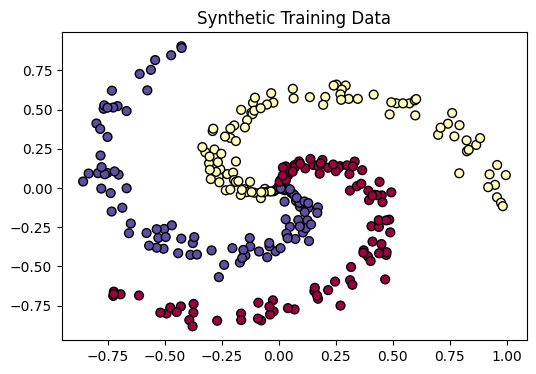


Model Architecture:
Sequential:
  Linear 2 -> 64
  BatchNormalization(features=64)
  ReLU
  Linear 64 -> 3
  LogSoftMax
Epoch 10/1000, Loss: 0.3412, Accuracy: 0.8867
Epoch 20/1000, Loss: 0.3255, Accuracy: 0.8733
Epoch 30/1000, Loss: 0.3813, Accuracy: 0.8633
Epoch 40/1000, Loss: 0.3518, Accuracy: 0.8700
Epoch 50/1000, Loss: 0.2292, Accuracy: 0.9167
Epoch 60/1000, Loss: 0.2501, Accuracy: 0.9200
Epoch 70/1000, Loss: 0.2690, Accuracy: 0.8967
Epoch 80/1000, Loss: 0.1940, Accuracy: 0.9267
Epoch 90/1000, Loss: 0.1873, Accuracy: 0.9200
Epoch 100/1000, Loss: 0.3284, Accuracy: 0.9033
Epoch 110/1000, Loss: 0.3590, Accuracy: 0.9033
Epoch 120/1000, Loss: 0.2643, Accuracy: 0.8967
Epoch 130/1000, Loss: 0.2522, Accuracy: 0.9200
Epoch 140/1000, Loss: 0.5914, Accuracy: 0.8433
Epoch 150/1000, Loss: 0.4107, Accuracy: 0.8733
Epoch 160/1000, Loss: 0.3018, Accuracy: 0.9033
Epoch 170/1000, Loss: 0.5558, Accuracy: 0.8167
Epoch 180/1000, Loss: 0.2391, Accuracy: 0.9100
Epoch 190/1000, Loss: 0.2297, Accuracy: 0.

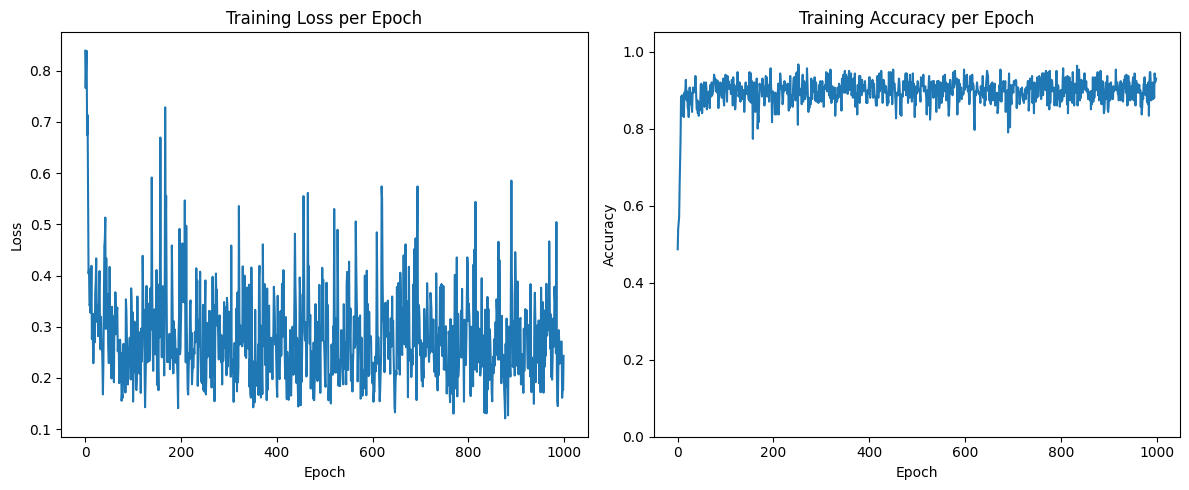

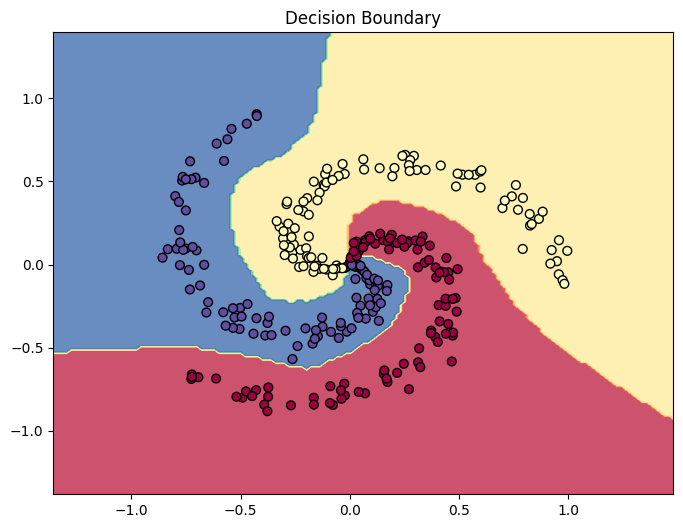

In [35]:
if __name__ == '__main__':
    if RUN_GRADIENT_CHECKS:
        run_all_gradient_checks()

    train_example_model()